In [ ]:
!nvidia-smi

Wed Jul 21 14:43:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    66W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -q -U watermark

In [ ]:
!pip install -qq transformers


In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.11
IPython version      : 5.5.0

numpy       : 1.19.5
pandas      : 1.1.5
torch       : 1.9.0+cu102
transformers: 4.8.2



In [ ]:

#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
#!unzip /content/drive/MyDrive/datasets.zip


Archive:  /content/drive/MyDrive/datasets.zip
replace datasets/classifiedExtremismAnsar.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
ls datasets/

classifiedExtremismAnsar.txt*        classifiedSentiment140_Test.txt*
classifiedExtremismTurnToIslam.txt*  classifiedSentiment140_Training.txt
classifiedMovies.txt*


In [ ]:
df_ext_trnislm = pd.read_csv('/content/datasets/classifiedExtremismTurnToIslam.txt', sep="\t", header=None, low_memory=False)

In [ ]:
df_ext_trnislm.columns = ["messageID",	"threadID",	"threadName",	"memberID",	"memberName",	"message" ,	"p_Date",	"threadFirstMessageID",	"scoreP",	"scoreN",	"polarity",	"termsP",	"termsN"]

In [ ]:
df = df_ext_trnislm

In [ ]:
del df_ext_trnislm

In [ ]:
df = df.drop(["messageID",	"threadID",	"threadName",	"memberID",	"memberName","p_Date",	"threadFirstMessageID",	"scoreP",	"scoreN",	"termsP",	"termsN"], axis=1)

In [ ]:
df['message'] = df['message'].astype(str)

In [ ]:
df.isna().sum()

message      0
polarity    66
dtype: int64

In [ ]:
df = df.dropna()

In [ ]:
df.isna().sum()

message     0
polarity    0
dtype: int64

In [ ]:
df.polarity.value_counts()

Inconclusive            690902
Positive Extreme        302178
Positive Non-Extreme      3828
Negative Extreme          3574
Negative Non-Extreme      2501
Name: polarity, dtype: int64

In [ ]:
def to_sentiment(rating):
  rating = str(rating)
  if rating == "Inconclusive":
    return 0
  elif rating == "Positive Extreme":
    return 1
  elif rating == "Negative Extreme":
    return 2
  elif rating == "Positive Non-Extreme":
    return 3
  else:
    return 4
df['label'] = df.polarity.apply(to_sentiment)

In [ ]:
class_names = ['Inconclusive', 'Positive Extreme', 'Negative Extreme','Positive Non-Extreme','Negative Non-Extreme']

In [ ]:
#df['label'] = pd.factorize(df['polarity'])[0]

In [ ]:
df.label.value_counts()

0    690902
1    302178
3      3828
2      3574
4      2501
Name: label, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


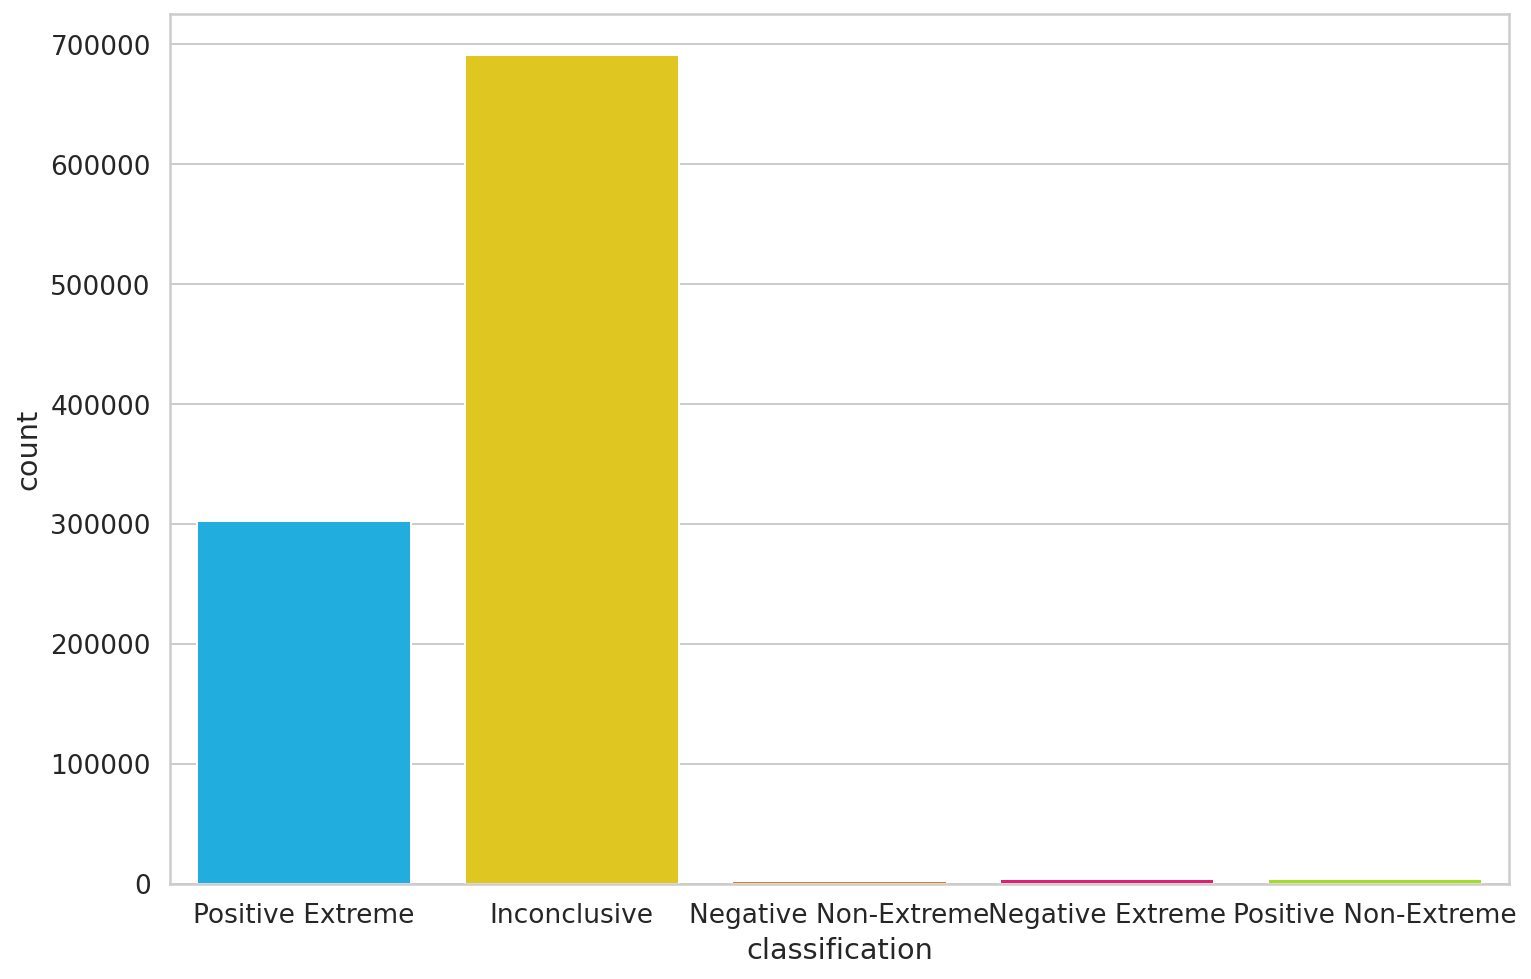

In [ ]:
sns.countplot(df.polarity)
plt.xlabel('classification');

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


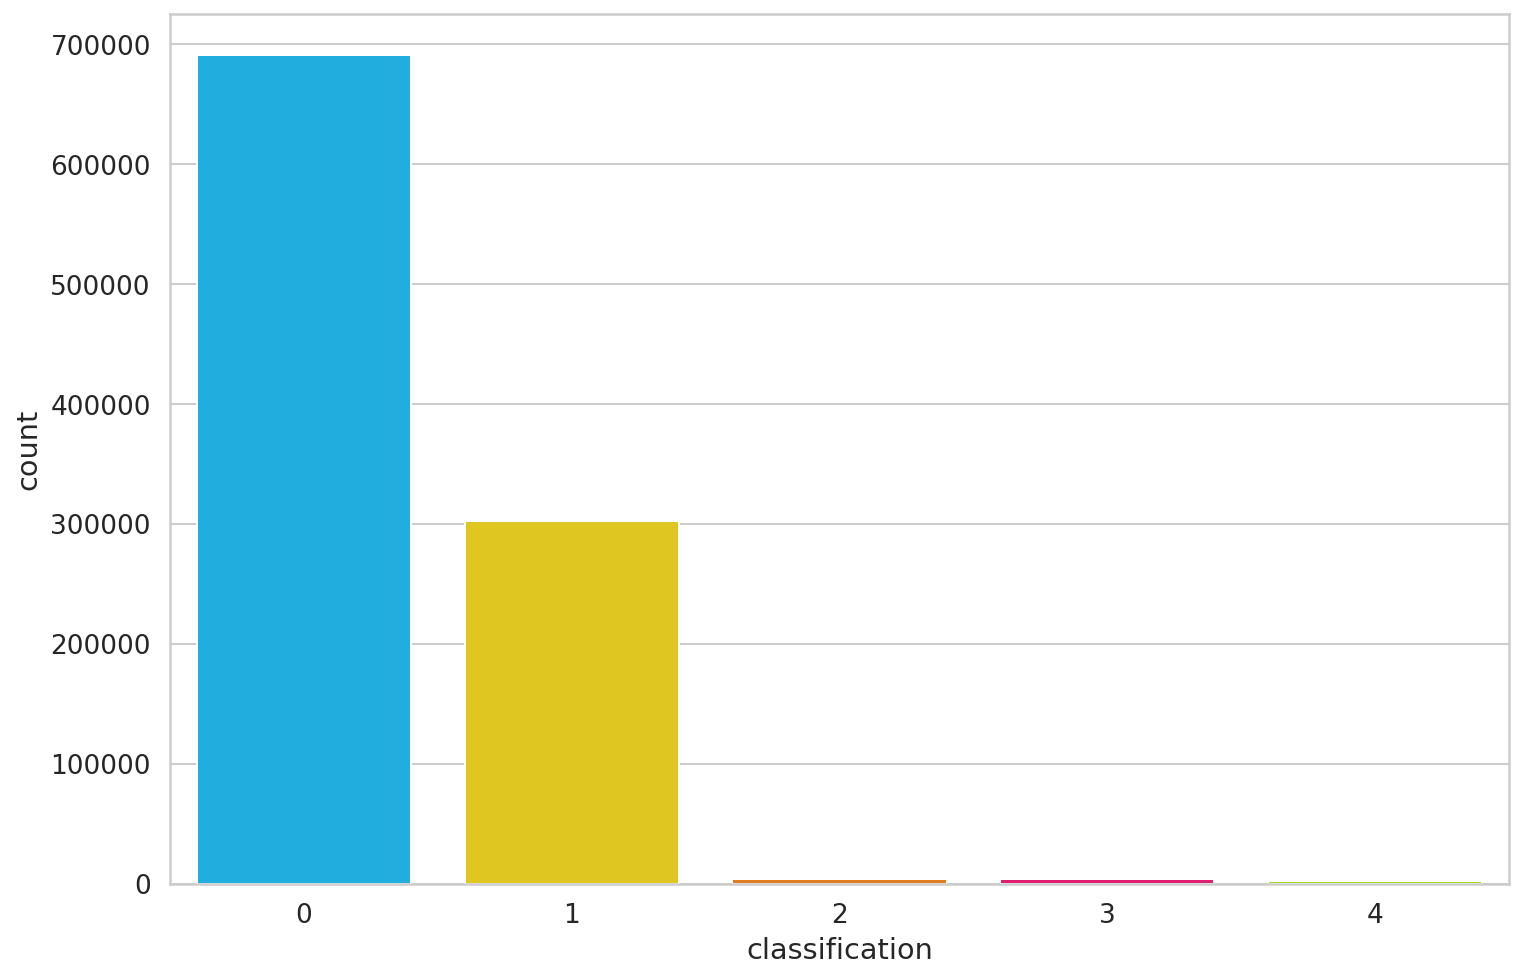

In [ ]:
sns.countplot(df.label)
plt.xlabel('classification');

In [ ]:
df.head()

,message,polarity,label
0,"Allaah says,“Verily, those who say, ‘Our Lord ...",Positive Extreme,1
1,As salamu alaikum wa rahmatullahi wabrakatuhu ...,Inconclusive,0
2,Asalaam Aluakim;When (if )did you decide to we...,Inconclusive,0
3,wrong it is me,Inconclusive,0
4,History of Islam in RussiaThe first Muslims at...,Positive Extreme,1


In [ ]:
df = df.drop("polarity",axis=1)

In [ ]:

def get_split(text):
    l_total = []
    l_parcial = []
    if len(text.split())//450 >0:
      n = len(text.split())//450
    else: 
      n = 1
    for w in range(n):
      if w == 0:
        l_parcial = text.split()[:500]
        l_total.append(" ".join(l_parcial))
      else:
        l_parcial = text.split()[w*450:w*450 + 500]
        l_total.append(" ".join(l_parcial))
    return l_total

In [ ]:
df['message_split'] = df['message'].apply(get_split)

In [ ]:
df['message_split']

0          [Allaah says,“Verily, those who say, ‘Our Lord...
1          [As salamu alaikum wa rahmatullahi wabrakatuhu...
2          [Asalaam Aluakim;When (if )did you decide to w...
3                                           [wrong it is me]
4          [History of Islam in RussiaThe first Muslims a...
                                 ...                        
1003044    [As salamu alaikum wa rahmatullahi wabrakatuhu...
1003045    [Quote:Originally Posted bymirajmomAnd we know...
1003046    [As salamu alaikum wa rahmatullahi wabrakatuhu...
1003047                 [thank you by the way i am a sister]
1003048                                    [........POSTING]
Name: message_split, Length: 1002983, dtype: object

In [ ]:
def data_augumentation(df, df_name):
    """
    Create a new dataframe from the original one because now one text may contain multiple subtexts of length 200. 
    Text correspond to subtexts from original text, while index correspond to its index of original set.
    """
    text_l = []
    label_l = []
    index_l = []
    for idx,row in df.iterrows():
      for l in row['message_split']:
        text_l.append(l)
        label_l.append(row['label'])
        index_l.append(idx)
    new_df = pd.DataFrame({'message':text_l, 'label':label_l, 'index':index_l})
    print("The " + df_name +" set now has " + str(len(new_df)) + ' subtexts extracted from ' + str(len(df)) + ' messsage.')
    return new_df



In [ ]:
df = data_augumentation(df, df_name = 'all')

The all set now has 1081637 subtexts extracted from 1002983 messsage.


In [ ]:
df.head()

,message,label,index
0,"Allaah says,“Verily, those who say, ‘Our Lord ...",1,0
1,"to human beings. Moreover, uttering this state...",1,0
2,As salamu alaikum wa rahmatullahi wabrakatuhu ...,0,1
3,Asalaam Aluakim;When (if )did you decide to we...,0,2
4,wrong it is me,0,3


In [ ]:

df.drop("index",axis=1)

,message,label
0,"Allaah says,“Verily, those who say, ‘Our Lord ...",1
1,"to human beings. Moreover, uttering this state...",1
2,As salamu alaikum wa rahmatullahi wabrakatuhu ...,0
3,Asalaam Aluakim;When (if )did you decide to we...,0
4,wrong it is me,0
...,...,...
1081632,As salamu alaikum wa rahmatullahi wabrakatuhuD...,0
1081633,Quote:Originally Posted bymirajmomAnd we know ...,0
1081634,As salamu alaikum wa rahmatullahi wabrakatuhuQ...,0
1081635,thank you by the way i am a sister,0


In [ ]:
#train_df = data_augumentation(df_train, df_name = 'training')
#val_df = data_augumentation(df_val, df_name  = 'validation')
#test_df = data_augumentation(df_test, df_name = 'testing')

In [ ]:
#df['message_len'] = df['message'].astype(str).apply(len)
#calculating the length of headlines and descriptions
df['message_len'] = df['message'].apply(lambda x: len(str(x).split()))

In [ ]:
df["message_len"].describe().apply(lambda x: format(x, 'f'))

count    1081637.000000
mean         121.351514
std          165.170655
min            1.000000
25%           13.000000
50%           42.000000
75%          142.000000
max          500.000000
Name: message_len, dtype: object

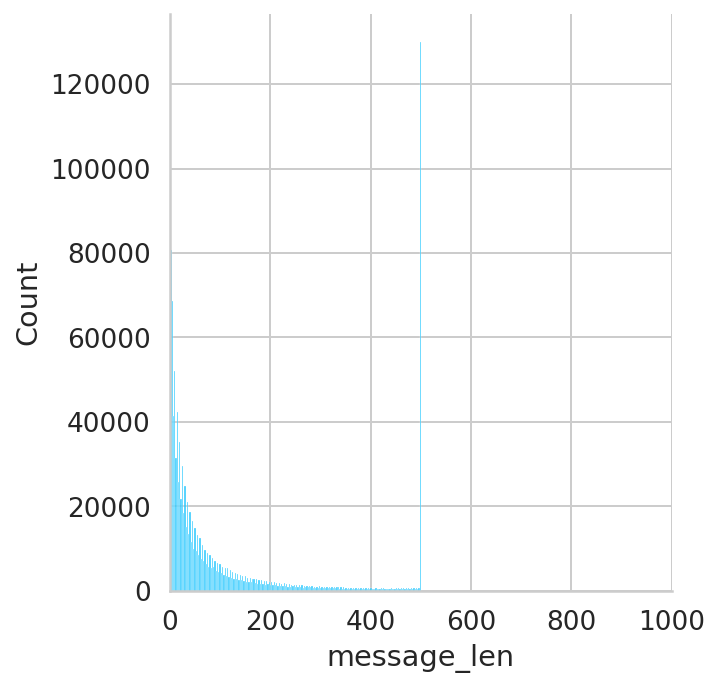

In [ ]:
sns.displot( df , x= "message_len" );
plt.xlim([0, 1000]);


In [ ]:
df.label.value_counts()


0    701655
1    366935
3      6349
2      3801
4      2897
Name: label, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


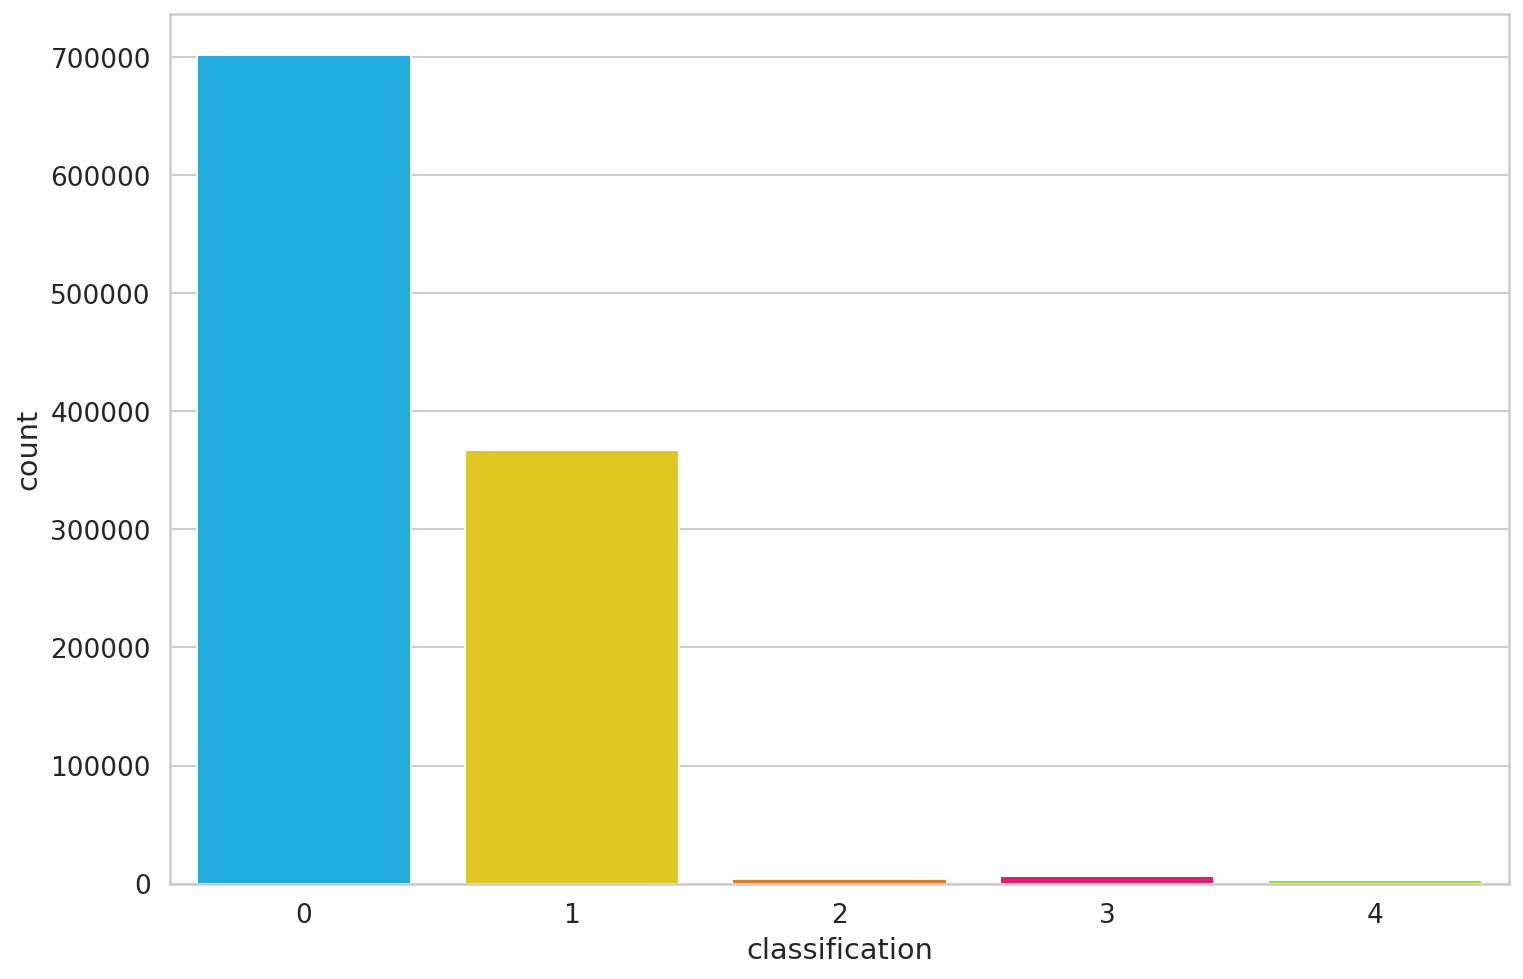

In [ ]:
sns.countplot(df.label)
plt.xlabel('classification');

In [ ]:
df.head()

,message,label,index,message_len
0,"Allaah says,“Verily, those who say, ‘Our Lord ...",1,0,500
1,"to human beings. Moreover, uttering this state...",1,0,500
2,As salamu alaikum wa rahmatullahi wabrakatuhu ...,0,1,32
3,Asalaam Aluakim;When (if )did you decide to we...,0,2,31
4,wrong it is me,0,3,4


In [ ]:
df = df.drop(columns= ["index","message_len"],axis=1)

In [ ]:

# Class count
count_class_0, count_class_1,count_class_2,count_class_3,count_class_4 = df.label.value_counts()

# Divide by class
df_class_0 = df[df['label'] == 0]
df_class_1 = df[df['label'] == 1]
df_class_2 = df[df['label'] == 2]
df_class_3 = df[df['label'] == 3]
df_class_4 = df[df['label'] == 4]

Random under-sampling:
4    2897
3    2897
2    2897
1    2897
0    2897
Name: label, dtype: int64


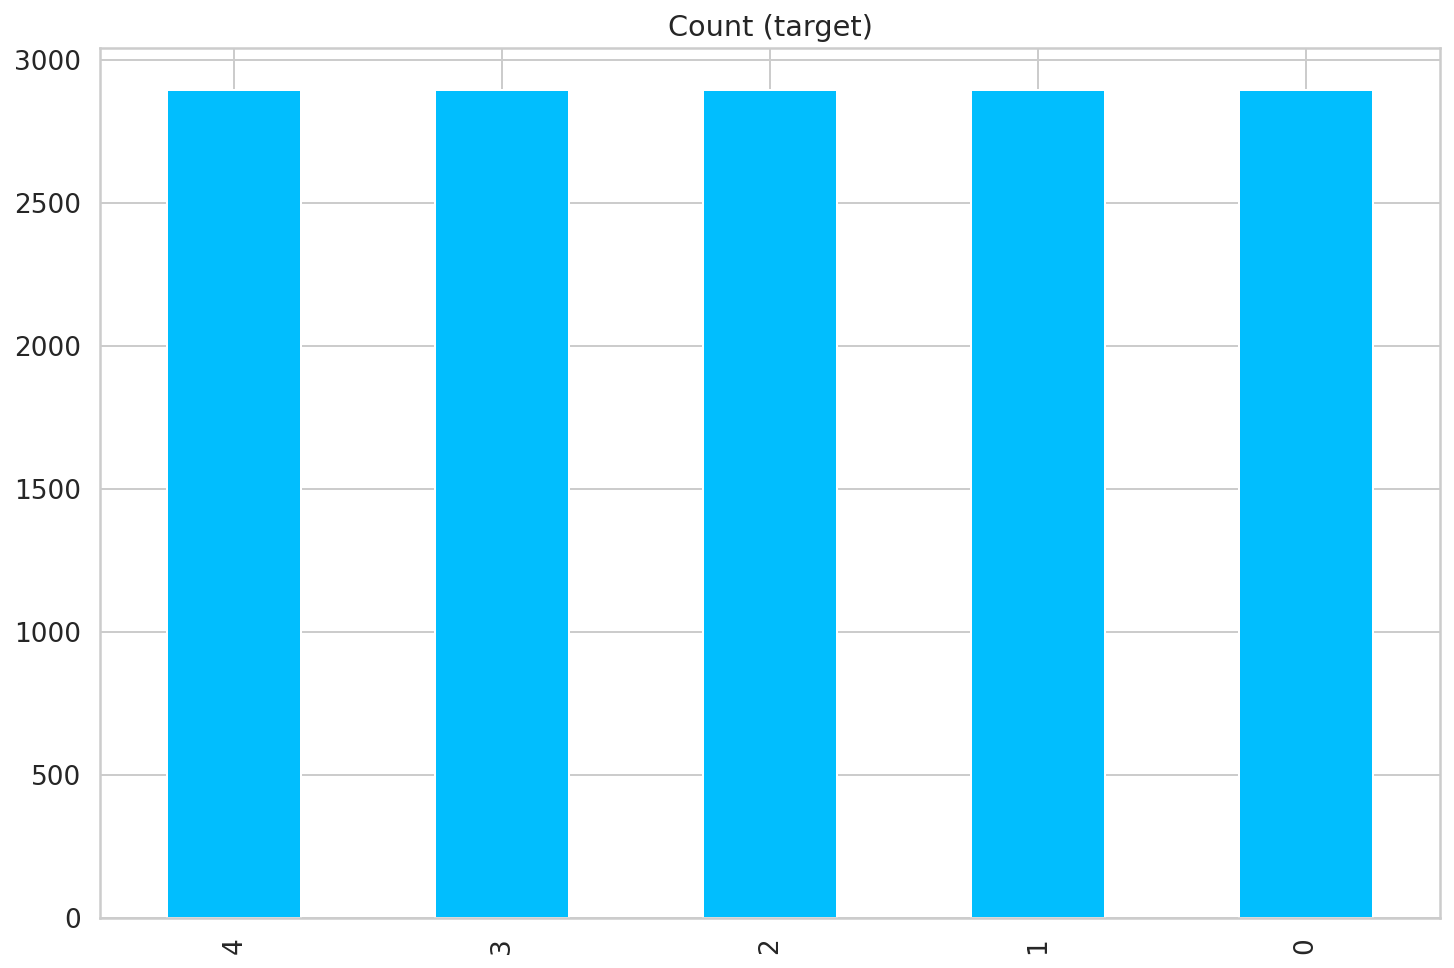

In [ ]:
df_class_0_under = df_class_0.sample(n=count_class_4,random_state = 12)
df_class_1_under = df_class_1.sample(count_class_4,random_state = 12)
df_class_2_under = df_class_2.sample(count_class_4,random_state = 12)
df_class_3_under = df_class_3.sample(count_class_4,random_state = 12)
df_test_under = pd.concat([df_class_0_under, df_class_1_under,df_class_2_under,df_class_3_under , df_class_4], axis=0)

print('Random under-sampling:')
print(df_test_under.label.value_counts())

df_test_under.label.value_counts().plot(kind='bar', title='Count (target)');

In [ ]:
df_test_under.head()

,message,label
884293,brother welcome may allah guide to the straigh...,0
853632,pokušajima da poprave stanje i da vidimo da se...,0
607204,no i dont ...do u like arbic nasheeds of english?,0
520345,Quote:Originally Posted bymalickabrotheryou ha...,0
1021843,You should try lemon tea. It tastes disgusting...,0


In [ ]:
df_test_under = df_test_under.sample(frac=1).reset_index(drop=True)

In [ ]:
df_test_under.head(10)

,message,label
0,then will be the delights of this world and th...,3
1,Quote:Originally Posted byhijab_sistercuz then...,2
2,Is a beautiful story mash’ Allah. May Allah pr...,0
3,"Salaam alaykum,I was on the wicked you tube an...",2
4,She didn't predict any thing bro. That's the o...,0
5,isolatepolitetripstripstripetripepolesplatessl...,0
6,I thought this was interesting to know.Does dr...,4
7,"good buy, drive safe",0
8,don't wanna leave TTI... love it here aww...Go...,2
9,May Allaah help u brother and all of us. I rem...,1


In [ ]:
df_train, df_test = train_test_split(
  df_test_under,
  test_size=0.2,
  random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((11588, 2), (1448, 2), (1449, 2))

In [ ]:
import torch

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda

Tesla K80
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:375: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


In [ ]:
#PRE_TRAINED_MODEL_NAME = "bert-base-multilingual-uncased"
PRE_TRAINED_MODEL_NAME = "bert-base-cased"

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)

In [ ]:
MAX_LEN = 512

In [ ]:
class ExtremsSentiDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):

    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      truncation=True,
      return_tensors='pt',
      
    )
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = ExtremsSentiDataset(
    reviews=df.message.to_numpy(),
    targets=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2,
    shuffle=True
  )

In [ ]:
BATCH_SIZE = 6

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)



In [ ]:
data = next(iter(train_data_loader))
data.keys()


dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:

model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([6, 512])
torch.Size([6, 512])


In [ ]:
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Tesla K80
Memory Usage:
Allocated: 0.4 GB
Cached:    0.5 GB


/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:375: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([6, 512])
torch.Size([6, 512])


In [ ]:

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Tesla K80
Memory Usage:
Allocated: 0.4 GB
Cached:    0.5 GB


/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:375: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.2622, 0.1982, 0.0801, 0.1719, 0.2876],
        [0.2116, 0.1425, 0.1238, 0.2694, 0.2527],
        [0.2520, 0.2435, 0.1238, 0.1719, 0.2089],
        [0.2346, 0.1698, 0.0993, 0.1875, 0.3089],
        [0.2140, 0.1577, 0.1443, 0.1977, 0.2863],
        [0.2207, 0.2135, 0.0974, 0.2364, 0.2320]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

In [ ]:
EPOCHS = 6
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Wed Jul 21 14:46:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    58W / 149W |   4495MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:


import torch

# Check GPU memory using nvidia-smi
#del train_data_loader
#del val_data_loader
#del test_data_loader
torch.cuda.empty_cache()
# Check GPU memory again

In [ ]:
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Tesla K80
Memory Usage:
Allocated: 3.8 GB
Cached:    3.9 GB


/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:375: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 6)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/6
------
Train loss 1.1145293984396334 accuracy 0.5308940283051432
Val   loss 0.7361683030420345 accuracy 0.7113259668508287

Epoch 2/6
------
Train loss 0.6993640578187054 accuracy 0.727908180876769
Val   loss 0.6276148529761771 accuracy 0.7617403314917127

Epoch 3/6
------
Train loss 0.5657798006179054 accuracy 0.7915947531929582
Val   loss 0.6202292331371241 accuracy 0.7624309392265193

Epoch 4/6
------
Train loss 0.4769594281847737 accuracy 0.8404383845357266
Val   loss 0.772578467267627 accuracy 0.7824585635359116

Epoch 5/6
------
Train loss 0.39653555621019676 accuracy 0.8865205384880911
Val   loss 0.982195109732195 accuracy 0.7769337016574586

Epoch 6/6
------
Train loss 0.32915104596469963 accuracy 0.9142216085605799
Val   loss 1.0992645073993794 accuracy 0.7748618784530387

CPU times: user 3h 43min 31s, sys: 1min 39s, total: 3h 45min 10s
Wall time: 3h 45min 4s


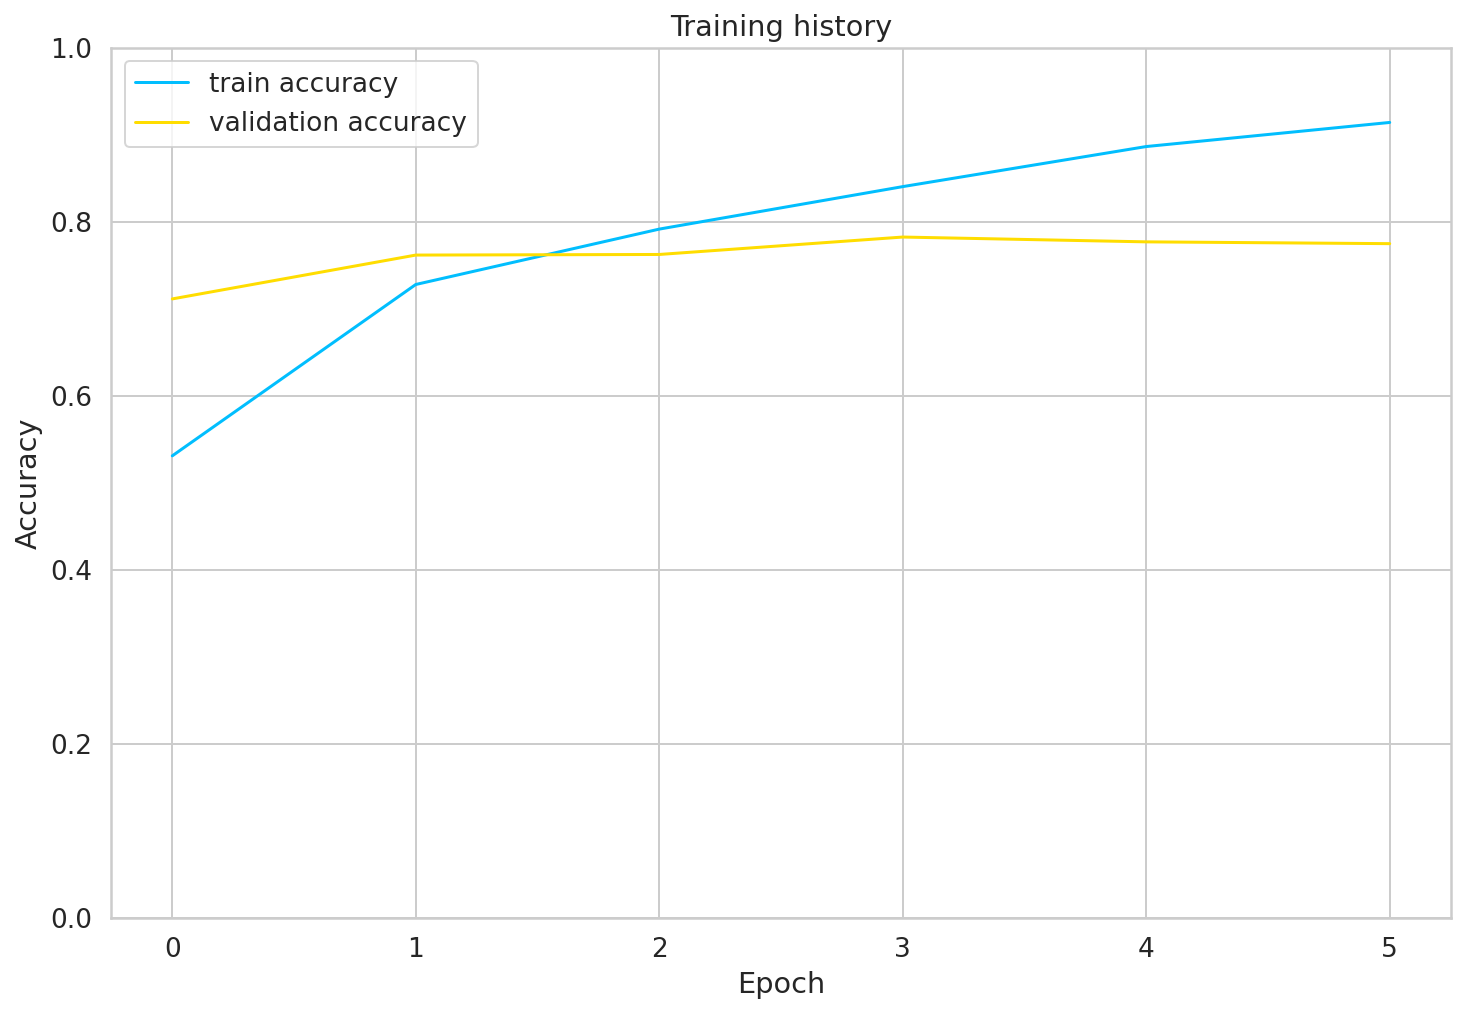

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()


0.7915804002760525

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

                      precision    recall  f1-score   support

        Inconclusive       0.96      0.94      0.95       282
    Positive Extreme       0.78      0.71      0.75       276
    Negative Extreme       0.94      0.85      0.89       329
Positive Non-Extreme       0.62      0.74      0.67       276
Negative Non-Extreme       0.68      0.70      0.69       286

            accuracy                           0.79      1449
           macro avg       0.80      0.79      0.79      1449
        weighted avg       0.80      0.79      0.79      1449



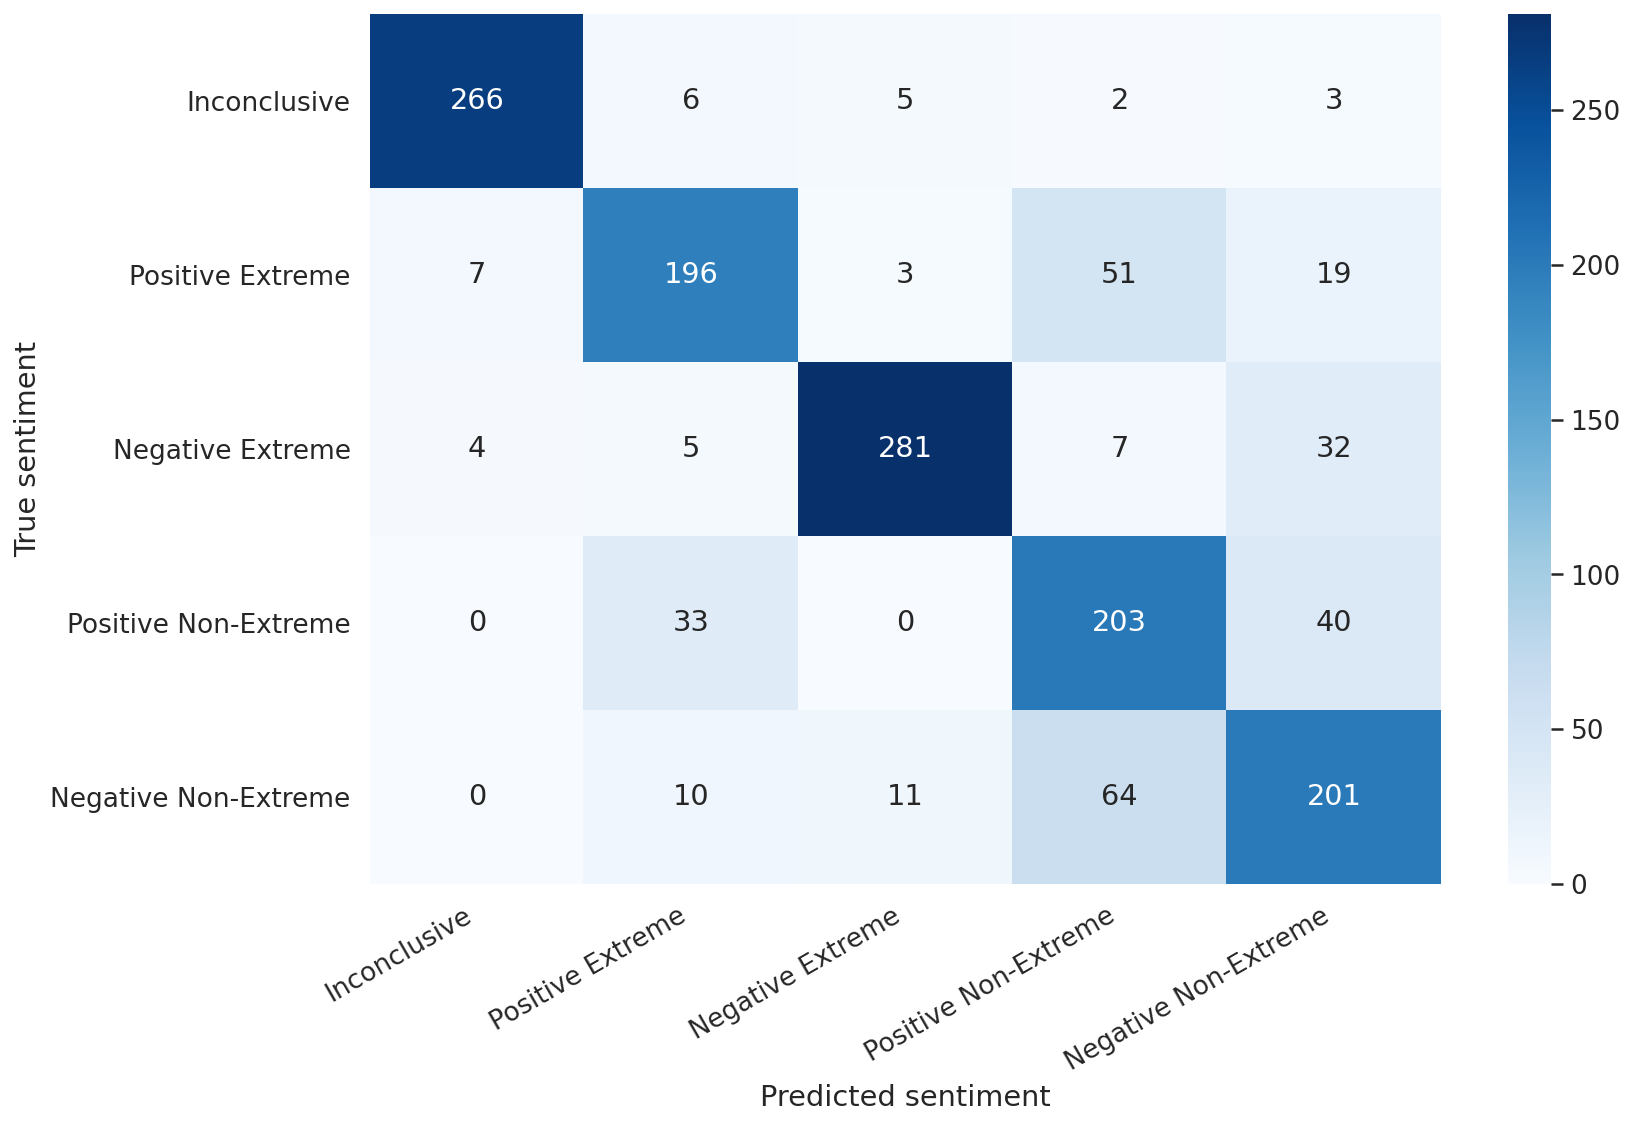

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)